## ECE495 In-class Exercise 3: Bubble Sort using Nengo

This ICE uses Nengo to sort an array using the bubble sort algorithm. The objectives of this ICE are to:

- Input any input array to automatically adjust the dimensions of your neuron nodes and ensembles required to sort your array. This will offer much cleaner code than that of Lecture 16 and will serve you well on your final project (hand jamming 30+ ensembles gets tedious).
- Connect neuron ensembles _for an array of 4 values_ to be sorted. Bonus points if you generalize this using `for` loops. Why? (a) it's not easy and (b) it's more of an exercise in Python programming knowledge, not Nengo knowledge.
- Understand why the output values are not exact and think through ways to fix that (hint: the answer is not more neurons! Sad...)

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [93]:
import matplotlib.pyplot as plt
import numpy as np

import nengo

from nengo.dists import Uniform
from nengo.utils.matplotlib import rasterplot

### Create your array to be sorted

Create the following 4-dimensional array by filling in `???`:
$\begin{bmatrix} -.5 & .6 & -.3 & .4  \end{bmatrix}$ 

In [94]:
input_array = np.array([-0.5, 0.6, -0.3, 0.4])

### Encode all inputs for sorting

Create the model and add input nodes, neuron ensembles and probes to visualize our encoded input array.

For info on how to create an "array" of nodes and ensembles, take a look [here](https://forum.nengo.ai/t/how-to-efficiently-create-nodes-for-each-features-in-your-dataset-can-we-use-size-in-in-nengo-node/2288/2). Ultimately, you are creating a multi-dimensional node using `input_array` as your argument and a multi-dimensional neuron ensemble using the argument `dimensions` with the appropriate number for your input array! 

Be sure to generalize this for lenght (i.e. I don't want to see something like dimension = 3 as an argument).

The cool part is that now you only need one probe to collect data from all of your input nodes and one probe to collect all of your inputs from your input neurons.

Fill in all `???` with the appropriate code.

In [95]:
# Create a model to perform the sorting
model = nengo.Network(label="SortArray")
with model:
    input_node = nengo.Node(input_array)

    # you will need number of neurons and number dimensions as input arguments
    input_neuron = nengo.Ensemble(100 * input_array.size, dimensions=input_array.size)
    # Using a for loop, connect all input nodes to input neuron ensembles to encode input
    for i in range(input_array.size):
        # Connect input nodes to input ensembles that will encode input
        nengo.Connection(input_node[i], input_neuron[i])

    # Add probes to your input nodes and neurons
    # Don't forget a synapse in order to decode neuron ensemble outputs
    input_probe_nodes = nengo.Probe(input_node)
    input_probe_neurons = nengo.Probe(input_neuron, synapse=0.01)

### Run it, plot it

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

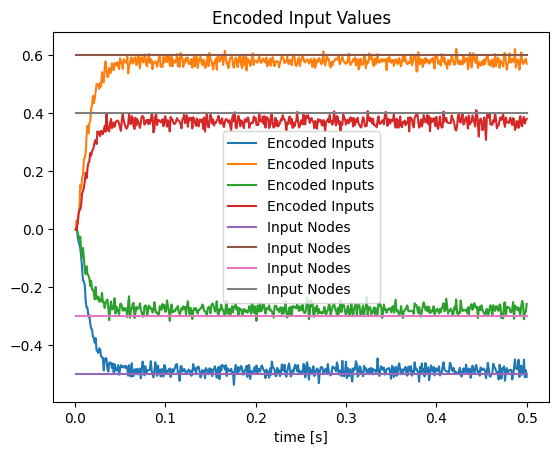

In [96]:
# Build the simulator to run the model containing just input encoding
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(0.5)

# Plot the input signals and decoded ensemble values
t = sim.trange()
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe_neurons], label="Encoded Inputs")
plt.plot(sim.trange(), sim.data[input_probe_nodes], label="Input Nodes")
plt.legend()
# plt.ylim(0, 1.5)
plt.xlabel("time [s]")
plt.title("Encoded Input Values")
plt.show()

### Set up neurons to perform the comparisons required for Bubble Sort

We need neuron ensembles to compare each of the inputs from left to right, two at a time.

From the details on the Bubble Sort algorithm, for an array of four values, you will need to perform a compare function 6 times to sort the array into ascending order. To generalize, you can compute [the function](https://en.wikipedia.org/wiki/Triangular_number)

$$\sum_ {k=1} ^{n-1} k = \frac{(n-1)n}{2}$$

or

$$nCr = \frac{n!}{r!(n-r)!}$$


Due to the nature of Nengo, for each of these nCr comparisons, we need a 2D neuron `combine_neuron_N` to take in the two digits to be compared, then connect the output of that neuron to a neuron that represents the greater value `larger_neuron_N` and a neuron that represents the smaller value `smaller_neuron_N`.

Notice that we set up all of these ensembles exactly as we did for our input encoding, except our comparator neurons are 2D to recieve two neuron inputs that will remain distinct inputs so they can be compared (versus all coming in at once, which would just add the input spikes).

**Do not hardcode the number of combinations or any of your dimensions!!**

Fill in all `???` with the appropriate code.

In [97]:
num_combos = int((input_array.size - 1) * input_array.size / 2)
print(num_combos)
with model:
    # you will need number of neurons and number dimensions as input arguments for all neuron ensembles

    combine_neuron = nengo.Ensemble(100 * num_combos * 2, dimensions=num_combos * 2)
    # no
    larger_neuron = nengo.Ensemble(100 * input_array.size, dimensions=num_combos)

    smaller_neuron = nengo.Ensemble(100 * input_array.size, dimensions=num_combos)

6


We now have neurons set aside to perform the comparison functions, but in order to actually do so the network must train weights to compute the comparison of two values at a time.

In Nengo, we define a function that trains weights between each `combine_neurons` and `larger_neurons` such that the greater value is returned from the `larger_neurons` ensemble.

Similarly we define a function that trains weights between each `combine_neurons` and `smaller_neurons` such that the lower value is returned from the `smaller_neurons` ensemble.

In [98]:
with model:
    # Create a function to return the largest value
    def higher_val(x):
        return np.max(x)

    # Create a function to return the smaller value
    def lower_val(x):
        return np.min(x)

## Connect all the things!

Now we need to connect all of our neurons to sort. Here's where things get messy! You may want to draw yourself a block diagram to know what goes where. 

**NOTE: you absolutely can generalize your connections if your'e feeling up to it. However, start with hardcoding for an array of 4 values. Bonus points if you can generalize and use `for` loops to assign connections!**

Hints:
- Your first two elements go into the first compare. Each subsequent element from there goes into the second, third, and so forth, respectively (i.e. 3rd element into 2nd compare, 4th element into 3rd compare, etc).
- Your `higher_neuron` outputs go into the following compare until you are at the end of your pass (i.e. the `higher_neuron` out of the first compare goes into the second compare, etc). At the end of your pass, you have your highest (now sorted) element for the pass and is therefore an output of your network (i.e. first pass leaves you with your highest element, second with your second highest, etc).
- You can repeat this process for each of the `lower_neuron` arrays. For the second pass, similarly the first two `lower_neuron` outputs go into the 1st compare, 3rd into the 2nd, etc.
- Use Lecture 16's notebook for reference on correct connections.

**You're rolling solo for this portion of the exercise, no `???`, just do it!**


In [99]:
with model:
    # This breakdown may be useful if you are hardcoding for a 4-element input array

    # -- FIRST PASS --
    # Compare 1
    nengo.Connection(input_neuron[0], combine_neuron[0])
    nengo.Connection(input_neuron[1], combine_neuron[1])

    nengo.Connection(combine_neuron[[0, 1]], smaller_neuron[0], function=lower_val)
    nengo.Connection(combine_neuron[[0, 1]], larger_neuron[0], function=higher_val)

    # Compare 2
    nengo.Connection(larger_neuron[0], combine_neuron[2])
    nengo.Connection(input_neuron[2], combine_neuron[3])

    nengo.Connection(combine_neuron[[2, 3]], smaller_neuron[1], function=lower_val)
    nengo.Connection(combine_neuron[[2, 3]], larger_neuron[1], function=higher_val)

    # Compare 3
    nengo.Connection(larger_neuron[1], combine_neuron[4])
    nengo.Connection(input_neuron[3], combine_neuron[5])

    nengo.Connection(combine_neuron[[4, 5]], smaller_neuron[2], function=lower_val)
    nengo.Connection(combine_neuron[[4, 5]], larger_neuron[2], function=higher_val)

    # -- SECOND PASS -- i=1
    # Compare 1
    nengo.Connection(smaller_neuron[0], combine_neuron[6])
    nengo.Connection(smaller_neuron[2], combine_neuron[7])

    nengo.Connection(combine_neuron[[6, 7]], smaller_neuron[3], function=lower_val)
    nengo.Connection(combine_neuron[[6, 7]], larger_neuron[3], function=higher_val)

    # Compare 2
    nengo.Connection(larger_neuron[3], combine_neuron[8])
    nengo.Connection(smaller_neuron[2], combine_neuron[9])

    nengo.Connection(combine_neuron[[8, 9]], smaller_neuron[4], function=lower_val)
    nengo.Connection(combine_neuron[[8, 9]], larger_neuron[4], function=higher_val)

    # -- THIRD PASS -- i=2
    # Compare 1
    nengo.Connection(smaller_neuron[3], combine_neuron[10])
    nengo.Connection(smaller_neuron[4], combine_neuron[11])

    nengo.Connection(
        combine_neuron[[10, 11]], smaller_neuron[5], function=lower_val
    )  # output 1
    nengo.Connection(
        combine_neuron[[10, 11]], larger_neuron[5], function=higher_val
    )  # output 2

    # For loop attempt
    # num_elements = 4  # Number of elements to sort
    # num_passes = input_array.size-1
    # for i in range(num_passes):
    #     for j in range(num_elements - 1 - i):
    #         # Indexing for combine neurons
    #         combine_idx = i *2* (num_elements - 1-j) + j
    #         next_comp_idx = j*2+1

    #         # Initial comparison
    #         if i == 0 and j==0:
    #             # Connect input neurons to combine neurons for comparison
    #             nengo.Connection(input_neuron[j], combine_neuron[combine_idx])
    #             nengo.Connection(input_neuron[j + 1], combine_neuron[combine_idx + 1])
    #         else:
    #             # Feedback mechanism: use the result of previous comparisons
    #             nengo.Connection(larger_neuron[combine_idx // 2 - 1], combine_neuron[next_comp_idx])
    #             if j != 0:  # For all but the first comparison in each pass
    #                 nengo.Connection(smaller_neuron[combine_idx // 2 - 1], combine_neuron[next_comp_idx + 1])

    #         # Connections from combine to larger and smaller neurons
    #         nengo.Connection(combine_neuron[[combine_idx, combine_idx + 1]], smaller_neuron[combine_idx // 2], function=lower_val)
    #         nengo.Connection(combine_neuron[[combine_idx, combine_idx + 1]], larger_neuron[combine_idx // 2], function=higher_val)

    #         # For the first comparison of each pass after the first, connect from the previous pass's smaller output
    #         if i > 0 and j == 0:
    #             nengo.Connection(smaller_neuron[(i - 1) * (num_elements - 1) - 1], combine_neuron[next_comp_idx + 1])

Add probes to the output so that we can see how well our neurons sorted our input array.

In [100]:
with model:
    # add probes to output neurons
    out_probe_smaller = nengo.Probe(smaller_neuron, synapse=0.1)
    out_probe_larger = nengo.Probe(larger_neuron, synapse=0.1)
    compare_probes = nengo.Probe(combine_neuron, synapse=0.01)

Create your simulator to run the neuron dynamics over time

In [101]:
with nengo.Simulator(model) as sim:
    # Run it for 2 seconds
    sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

### Plot the data!

You will need to probe the appropriate output probes to show your final sorted array. For instance, your largest value will likely be `sim.data[out_probe_larger][:,2]` if you do your first pass comparisons using the first 3 comparison pairs out of your `combine_neurons`.

Input Array = [-0.5  0.6 -0.3  0.4]
output


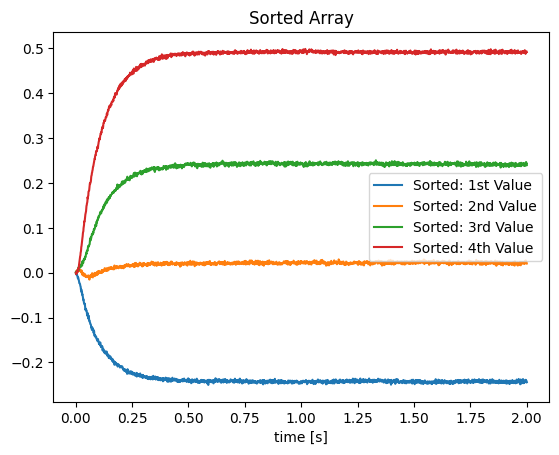

In [102]:
print("Input Array =", input_array)
print(
    "output",
)
## Plot the results!
# Plot the input signals and decoded ensemble values
t = sim.trange()
plt.figure()
plt.plot(sim.trange(), sim.data[out_probe_smaller][:, 5], label="Sorted: 1st Value")
plt.plot(sim.trange(), sim.data[out_probe_larger][:, 5], label="Sorted: 2nd Value")
plt.plot(sim.trange(), sim.data[out_probe_larger][:, 4], label="Sorted: 3rd Value")
plt.plot(sim.trange(), sim.data[out_probe_larger][:, 0], label="Sorted: 4th Value")
# plt.plot(sim.trange(), sim.data[compare_probes][:,1], label="combine")
plt.legend()
# plt.ylim(0, 1.5)
plt.xlabel("time [s]")
plt.title("Sorted Array")
plt.show()

## Discussion

Notice that your output values are not precise. Consider why:
- Your inputs go directly into your 12-dimensional combine neuron ensemble
- For your third input array element, it gets compared to an output from the combine neuron - which means there's a delay on that input! 
- This means your output of the 2nd set of comparison functions is _biased_ by your input. 
- This bias gets propogated throughout your computations. 
- You can see this happening in the decoded outputs - it fluctuates up and down for your second and third sorted values.

**Ensure this makes sense to you! It will be a common issue as we continue to map algorithms to neurons.**
